In [71]:
import pandas as pd 
import numpy as np

# библиотеки для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("viridis", as_cmap=True)
plt.rc('figure', figsize=(10,10))

# Шаг 1. Первичный анализ данных и их подготовка к дальнейшей работе.

In [72]:
# сначала просто посмотрим на таблицу
df = pd.read_csv('Downloads/SpaceshipTitanic/train.csv')
print('Размер датасета: ', df.shape)
df.head()

Размер датасета:  (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. 
Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [73]:
# у меня уже есть несколько идей по обработке, но сначала стоит посмотреть на типы данных
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [74]:
# посмотрим на элементы поподробнее
for i in df.columns:
    print(i)
    print(f'Количество уникальных элементов: {len(df[i].unique())} \nПеречень уникальных элементов: {df[i].unique()}')
    print('-'*50)

PassengerId
Количество уникальных элементов: 8693 
Перечень уникальных элементов: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
--------------------------------------------------
HomePlanet
Количество уникальных элементов: 4 
Перечень уникальных элементов: ['Europa' 'Earth' 'Mars' nan]
--------------------------------------------------
CryoSleep
Количество уникальных элементов: 3 
Перечень уникальных элементов: [False True nan]
--------------------------------------------------
Cabin
Количество уникальных элементов: 6561 
Перечень уникальных элементов: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
--------------------------------------------------
Destination
Количество уникальных элементов: 4 
Перечень уникальных элементов: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
--------------------------------------------------
Age
Количество уникальных элементов: 81 
Перечень уникальных элементов: [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48.

К сожалению, тут имеются пропущенные значения, обозначенные как nan, придется с ними поработать.

## 1.1. Работа с пропущенными значениями.

In [75]:
# посмотрим, где и сколько пропусков
def nan(dfr):
    df_nan = dfr.isna().sum().reset_index()
    df_nan = df_nan.rename(columns={'index':'column', 0:'total_missing'})
    df_nan['percent_missing'] = df_nan['total_missing']*100/dfr.shape[0]
    return df_nan
nan(df)

,column,total_missing,percent_missing
0,PassengerId,0,0.000000
1,HomePlanet,201,2.312205
2,CryoSleep,217,2.496261
3,Cabin,199,2.289198
4,Destination,182,2.093639
5,Age,179,2.059128
6,VIP,203,2.335212
7,RoomService,181,2.082135
8,FoodCourt,183,2.105142
9,ShoppingMall,208,2.392730


In [76]:
# теперь посмотрим, какой процент от всего датасета они составляют
print('Процент пропущенных значений: ', sum(df.isna().sum())*100/df.shape[0])
print('Количество пропущенных значений: ', sum(df.isna().sum()))

Процент пропущенных значений:  26.734153916944667
Количество пропущенных значений:  2324


Очевидно, что в такой ситуации просто выбросить строчки с пропущенными значениями нельзя, поэтому попробуем что-нибудь другое.

С возрастом вряд ли что-то можно сделать, а вот с остальными параметрами можно попробовать поиграть.

### Сначала посмотрим на пропущенные значения в столбцах RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

In [77]:
for i in ['RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck']: 
    print(i)
    print(df.loc[df[i].isna()].head())
    print('-'*50)
# У меня есть некоторые подозрения, связанные с тем, что, возможно, трат просто не было, проверим еще кое-что

RoomService
    PassengerId HomePlanet CryoSleep   Cabin    Destination   Age    VIP  \
25      0020_05      Earth      True   E/0/S  PSO J318.5-22   1.0  False   
35      0031_03       Mars     False   F/9/P    TRAPPIST-1e  20.0  False   
83      0091_01      Earth      True  G/16/S    TRAPPIST-1e  26.0  False   
132     0141_01       Mars     False  F/30/P    TRAPPIST-1e  31.0  False   
170     0193_02       Mars     False  F/41/P    TRAPPIST-1e  23.0  False   

     RoomService  FoodCourt  ShoppingMall     Spa  VRDeck             Name  \
25           NaN        0.0           0.0     0.0     0.0  Mael Brantuarez   
35           NaN        0.0        1750.0   990.0     0.0     Dontch Datie   
83           NaN        0.0           0.0     0.0     0.0  Deanne Yorkland   
132          NaN        0.0          97.0     0.0     0.0     Pyrohs Harte   
170          NaN        0.0           8.0  1072.0     0.0        Frook Raf   

     Transported  
25         False  
35          True  
83   

In [78]:
df.loc[df['RoomService'].isna()]['VIP'].value_counts()
# Угу, кажется, что по большей части это люди без випа. В таком случае полагаю, замена nan на 0 будет весьма логичной
for i in ['RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck']: 
    df[i] = df[i].fillna(0)

In [79]:
# посмотрим на пропущенные значения снова
print('Процент пропущенных значений: ', sum(df.isna().sum())*100/df.shape[0])
print('Количество пропущенных значений: ', sum(df.isna().sum()))

Процент пропущенных значений:  15.886345335327276
Количество пропущенных значений:  1381


### HomePlanet, CryoSleep, Cabin, Destination скорее всего совпадают у членов одной семьи/группы.

Создадим дополнительные признаки, отвечающие за группу пассажира и фамилию его семьи

In [80]:
df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])

df['Name'] = df['Name'].fillna(0)
df['Family'] = df['Name'].apply(lambda x: None if x==0 else x.split(' ')[1])

# посмотрим не является ли столбец с фамилией избыточным с учетом группы
print(np.array([len(m) for m in df.groupby('Group')['Family'].unique()]).mean())
# ЯВЛЯЕТСЯ:) Выкинем его тогда

df.drop(['PassengerId', 'Name', 'Family'], axis=1, inplace=True)

1.0595142351616536


In [81]:
# Посмотрим, правильно ли мое предположение о совпадении значений данных столбцов к членов одной группы
for i in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination']:
    print(i, '\n')
    print(np.array([len(m) for m in df.groupby('Group')[i].unique()]).mean())
    print('-'*50)
# Да, все отлично. В среднем значения в этих слобцах у членов одной группы одни и те же

HomePlanet 

1.014315586295641
--------------------------------------------------
CryoSleep 

1.147659642914589
--------------------------------------------------
Cabin 

1.0871803120476113
--------------------------------------------------
Destination 

1.135917645166479
--------------------------------------------------


#### Сразу создадим признак, отвечающий за размер группы, чтобы посмотреть, будет ли вообще наше преобразование иметь смысл (просто, если в большинстве строк с пропущенными значениями в группе всего один человек, то мы вряд ли сможем с этим что-то сделать)

In [82]:
# Создаем столбец считающий число человек в каждой группе
df['GroupSize'] = df.groupby('Group')['Group'].transform('count')

# Смотрим на квартили и среднее значение нашего столбца
df.loc[df['HomePlanet'].isna()]['GroupSize'].describe()

count    201.000000
mean       2.009950
std        1.483206
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: GroupSize, dtype: float64

Преобразования не покроют 50% пропусков, но хотя бы от 25% мы избавимся, так что выполним преобразование

In [83]:
df['HomePlanet'] = df['HomePlanet'].fillna(df['Group'].map(dict(df.groupby('Group')['HomePlanet'].first())))
df['HomePlanet'].isna().sum()

111

Проделаем тоже самое с остальными столбцами (я напишу функцию, потому что так быстрее:)).

In [84]:
def working_with_na(col):
    print('Количество пропусков до преобразования: ', df[col].isna().sum())
    print(df.loc[df[col].isna()]['GroupSize'].describe())
    df[col] = df[col].fillna(df['Group'].map(dict(df.groupby('Group')[col].first())))
    print('Количество пропусков после преобразования: ', df[col].isna().sum())

for i in ['CryoSleep', 'Cabin', 'Destination']:
    print(i)
    working_with_na(i)
    print('-'*50)

CryoSleep
Количество пропусков до преобразования:  217
count    217.000000
mean       2.175115
std        1.629226
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: GroupSize, dtype: float64
Количество пропусков после преобразования:  109
--------------------------------------------------
Cabin
Количество пропусков до преобразования:  199
count    199.000000
mean       2.241206
std        1.795649
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: GroupSize, dtype: float64
Количество пропусков после преобразования:  99
--------------------------------------------------
Destination
Количество пропусков до преобразования:  182
count    182.000000
mean       1.989011
std        1.625042
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        8.000000
Name: GroupSize, dtype: float64
Количество пропусков после преобразования:  103
----------------

In [85]:
# посмотрим на пропущенные значения снова
print('Процент пропущенных значений: ', sum(df.isna().sum())*100/df.shape[0])
print('Количество пропущенных значений: ', sum(df.isna().sum()))

Процент пропущенных значений:  9.248820890371563
Количество пропущенных значений:  804


In [86]:
nan(df)

,column,total_missing,percent_missing
0,HomePlanet,111,1.276889
1,CryoSleep,109,1.253882
2,Cabin,99,1.138847
3,Destination,103,1.184861
4,Age,179,2.059128
5,VIP,203,2.335212
6,RoomService,0,0.000000
7,FoodCourt,0,0.000000
8,ShoppingMall,0,0.000000
9,Spa,0,0.000000


### Разберемся со столбцом VIP. Посмотрим на среднее значение трат и в случае значимых отличий воспользуемся им.

In [87]:
df['TotalSpendings'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

In [88]:
df.groupby('VIP')['TotalSpendings'].describe()

,count,mean,std,min,25%,50%,75%,max
VIP,,,,,,,,
False,8291.0,1371.504644,2683.701966,0.0,0.0,705.0,1369.0,35987.0
True,199.0,4425.477387,5121.300417,0.0,1281.0,2767.0,6120.5,31076.0


In [89]:
df['VIP'] = df['VIP'].fillna(df['TotalSpendings'].apply(lambda x: True if x>=2767.0 else 0))

In [90]:
# посмотрим на пропущенные значения снова
print('Процент пропущенных значений: ', sum(df.isna().sum())*100/df.shape[0])
print('Количество пропущенных значений: ', sum(df.isna().sum()))

Процент пропущенных значений:  6.913608650638444
Количество пропущенных значений:  601


In [91]:
nan(df)

,column,total_missing,percent_missing
0,HomePlanet,111,1.276889
1,CryoSleep,109,1.253882
2,Cabin,99,1.138847
3,Destination,103,1.184861
4,Age,179,2.059128
5,VIP,0,0.000000
6,RoomService,0,0.000000
7,FoodCourt,0,0.000000
8,ShoppingMall,0,0.000000
9,Spa,0,0.000000


### Мы сократили число пропусков до 7% от всей выборки, и я не думаю, что можно еще что-то сделать (ну в теории, конечно, можно написать отдельный алгоритм похожий на knn, который будет эти пропуски заполнять, но тут их уже не так уж и много, поэтому просто избавимся от них:))

In [92]:
df.dropna(inplace=True)

## 1.2. Разберемся с типами данных.

In [93]:
df.dtypes

HomePlanet         object
CryoSleep          object
Cabin              object
Destination        object
Age               float64
VIP                object
RoomService       float64
FoodCourt         float64
ShoppingMall      float64
Spa               float64
VRDeck            float64
Transported          bool
Group              object
GroupSize           int64
TotalSpendings    float64
dtype: object

In [94]:
df['VIP'] = df['VIP'].astype('bool')
df['CryoSleep'] = df['CryoSleep'].astype('bool')

df['HomePlanet'] = df['HomePlanet'].astype('category')
df['Destination'] = df['Destination'].astype('category')
df['Group'] = df['Group'].astype('category')
df['GroupSize'] = df['GroupSize'].astype('category')

In [95]:
df.dtypes

HomePlanet        category
CryoSleep             bool
Cabin               object
Destination       category
Age                float64
VIP                   bool
RoomService        float64
FoodCourt          float64
ShoppingMall       float64
Spa                float64
VRDeck             float64
Transported           bool
Group             category
GroupSize         category
TotalSpendings     float64
dtype: object

## 1.3. Столбец Cabin               

По условию, кабина определяется тремя разными значениями: deck/num/side. Я предлагаю пока что оставить только deck и side. 

При необходимости добавим и номер.

In [96]:
df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0]).astype('category')
df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2]).astype('category')
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,GroupSize,TotalSpendings,Deck,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,1,0.0,B,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,1,736.0,F,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,2,10383.0,A,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,2,5176.0,A,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,1,1091.0,F,S


In [97]:
df.drop('Cabin', axis=1, inplace=True)

In [98]:
df.drop('Group', axis=1, inplace=True)

# 2. Анализ взаимосвязей признаков.

## 2.1 Числовые признаки

In [102]:
# Выбираем числовые признаки в отдельный список
numeric = list(df.select_dtypes(include='number').columns)
numeric

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'TotalSpendings']

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>],
       [<AxesSubplot:title={'center':'ShoppingMall'}>,
        <AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>],
       [<AxesSubplot:title={'center':'TotalSpendings'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

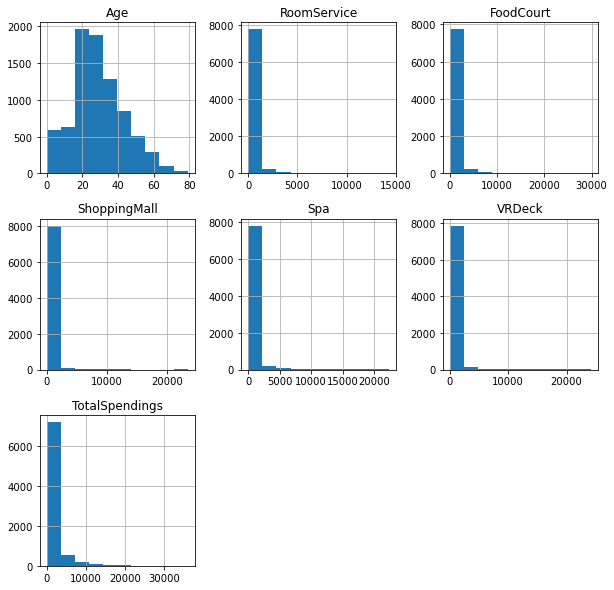

In [103]:
# Посмотрим на рапределения числовых признаков
df[numeric].hist()

<AxesSubplot:>

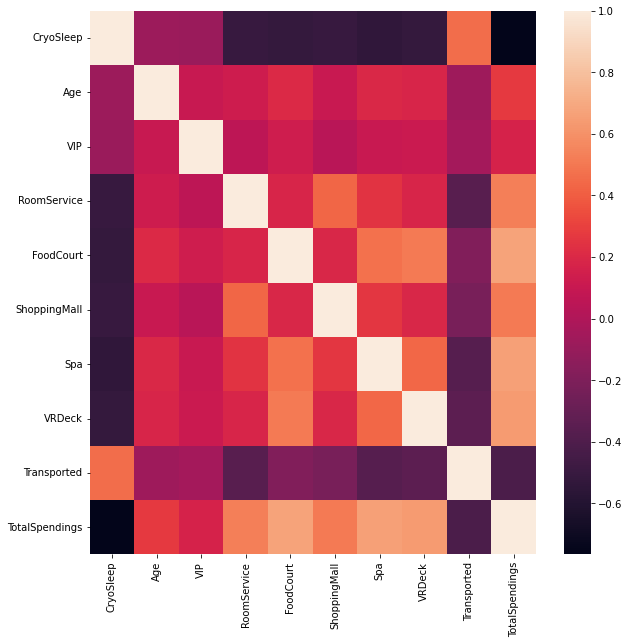

In [104]:
# Смотрим на корреляцию Спирмена, потому что признаки распределены не нормально
sns.heatmap(df.corr(method='spearman'))

In [105]:
df.corr(method='spearman')

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpendings
CryoSleep,1.000000,-0.077662,-0.088973,-0.509154,-0.524539,-0.507166,-0.540834,-0.520473,0.459832,-0.766313
Age,-0.077662,1.000000,0.103001,0.129532,0.205706,0.106052,0.198760,0.181576,-0.075086,0.270935
VIP,-0.088973,0.103001,1.000000,0.056935,0.133724,0.036447,0.106284,0.110952,-0.042204,0.167905
RoomService,-0.509154,0.129532,0.056935,1.000000,0.180062,0.428500,0.243862,0.179184,-0.365176,0.530110
FoodCourt,-0.524539,0.205706,0.133724,0.180062,1.000000,0.189133,0.473889,0.504310,-0.188969,0.669408
ShoppingMall,-0.507166,0.106052,0.036447,0.428500,0.189133,1.000000,0.255106,0.189352,-0.226830,0.508650
Spa,-0.540834,0.198760,0.106284,0.243862,0.473889,0.255106,1.000000,0.440002,-0.367366,0.660322
VRDeck,-0.520473,0.181576,0.110952,0.179184,0.504310,0.189352,0.440002,1.000000,-0.342971,0.636710
Transported,0.459832,-0.075086,-0.042204,-0.365176,-0.188969,-0.226830,-0.367366,-0.342971,1.000000,-0.419385
TotalSpendings,-0.766313,0.270935,0.167905,0.530110,0.669408,0.508650,0.660322,0.636710,-0.419385,1.000000


Видим достаточно большие корреляции между признаками, отвечающими за различные траты. В принципе оно и понятно:)

## 2.2. Взаимосвязь категориальных признаков с таргетом

In [106]:
from scipy.stats import chi2_contingency

In [117]:
for i in df.select_dtypes(include='category').columns:
    print('-'*30)
    table = pd.crosstab(df['Transported'], df[i])
    print('\nФАКТИЧЕСКИЕ ЧАСТОТЫ\n', table)
    _, p_value, _, tab = chi2_contingency(table)
    print('П УРОВЕНЬ ЗНАЧИМОСТИ: ', np.round(p_value, decimals=5))
    print('\nТЕОРИТИЧЕСКИЕ ЧАСТОТЫ\n', tab)

------------------------------

ФАКТИЧЕСКИЕ ЧАСТОТЫ
 HomePlanet   Earth  Europa  Mars
Transported                     
False         2502     699   805
True          1858    1363   885
П УРОВЕНЬ ЗНАЧИМОСТИ:  0.0

ТЕОРИТИЧЕСКИЕ ЧАСТОТЫ
 [[2153.12623274 1018.29043393  834.58333333]
 [2206.87376726 1043.70956607  855.41666667]]
------------------------------

ФАКТИЧЕСКИЕ ЧАСТОТЫ
 Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
Transported                                         
False                678            372         2956
True                1057            382         2667
П УРОВЕНЬ ЗНАЧИМОСТИ:  0.0

ТЕОРИТИЧЕСКИЕ ЧАСТОТЫ
 [[ 856.80596647  372.3525641  2776.84146943]
 [ 878.19403353  381.6474359  2846.15853057]]
------------------------------

ФАКТИЧЕСКИЕ ЧАСТОТЫ
 GroupSize       1    2    3    4    5    6    7   8
Transported                                        
False        2358  758  409  145  108   64  104  60
True         1952  882  595  259  151  105  123  39
П УРО